# Predicting Credit Card Default


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.linear_model  import LogisticRegressionCV

## Data


In [2]:
credit=pd.read_csv('UCI_Credit_Card.csv',index_col=0)
credit.shape

(30000, 24)

In [3]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



## Part 1. Data Munging
### Import response variable 

In [4]:
Data=pd.DataFrame()
Data['Y']=credit['default.payment.next.month']

### Create new features

In [5]:
credit['PAY']=0.3*credit['PAY_0']+0.2*credit['PAY_2']+0.15*credit['PAY_3']+0.15*credit['PAY_4']+0.1*credit['PAY_5']+0.1*credit['PAY_6']
credit['BILL_AMT']=0.3*credit['BILL_AMT1']+0.2*credit['BILL_AMT2']+0.15*credit['BILL_AMT3']+0.15*credit['BILL_AMT4']+0.1*credit['BILL_AMT5']+0.1*credit['BILL_AMT6']
credit['PAY_AMT']=0.3*credit['PAY_AMT1']+0.2*credit['PAY_AMT2']+0.15*credit['PAY_AMT3']+0.15*credit['PAY_AMT4']+0.1*credit['PAY_AMT5']+0.1*credit['PAY_AMT6']

In [6]:
col_list=credit.columns[4:23]
col_list=col_list.append(credit.columns[24:27])
col_list=col_list.insert(0,credit.columns[0])
col_list

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'PAY', 'BILL_AMT', 'PAY_AMT'],
      dtype='object')

In [7]:
credit['log1p_'+col_list]=np.log1p(credit[col_list])
credit['1over_'+col_list]=1/(credit[col_list])

<ipython-input-7-3a984573c2f6>:1: RuntimeWarning: divide by zero encountered in log1p
  credit['log1p_'+col_list]=np.log1p(credit[col_list])
<ipython-input-7-3a984573c2f6>:1: RuntimeWarning: invalid value encountered in log1p
  credit['log1p_'+col_list]=np.log1p(credit[col_list])


In [8]:
credit=credit.fillna(0)
credit=credit.replace(np.inf,0)
credit=credit.replace(-np.inf,0)

### Standardize numerical variables

In [9]:
col_list=credit.columns[4:23]
col_list=col_list.append(credit.columns[24:])
col_list=col_list.insert(0,credit.columns[0])
col_list

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'PAY', 'BILL_AMT', 'PAY_AMT',
       'log1p_LIMIT_BAL', 'log1p_AGE', 'log1p_PAY_0', 'log1p_PAY_2',
       'log1p_PAY_3', 'log1p_PAY_4', 'log1p_PAY_5', 'log1p_PAY_6',
       'log1p_BILL_AMT1', 'log1p_BILL_AMT2', 'log1p_BILL_AMT3',
       'log1p_BILL_AMT4', 'log1p_BILL_AMT5', 'log1p_BILL_AMT6',
       'log1p_PAY_AMT1', 'log1p_PAY_AMT2', 'log1p_PAY_AMT3', 'log1p_PAY_AMT4',
       'log1p_PAY_AMT5', 'log1p_PAY_AMT6', 'log1p_PAY', 'log1p_BILL_AMT',
       'log1p_PAY_AMT', '1over_LIMIT_BAL', '1over_AGE', '1over_PAY_0',
       '1over_PAY_2', '1over_PAY_3', '1over_PAY_4', '1over_PAY_5',
       '1over_PAY_6', '1over_BILL_AMT1', '1over_BILL_AMT2', '1over_BILL_AMT3',
       '1over_BILL_AMT4', '1over_BILL_AMT5', '1over_BILL_AMT6',
       '1over_PAY_AM

In [10]:
Data['standard_'+col_list]=(credit[col_list]-credit[col_list].min())/(credit[col_list].max()-credit[col_list].min())

In [11]:
Data.head()

,Y,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,standard_PAY_5,standard_PAY_6,standard_BILL_AMT1,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0.010101,0.051724,0.4,0.4,0.1,0.1,0.0,0.0,0.149982,...,0.500000,0.000000,0.001451,0.000000,0.000000,0.000000,0.000000,0.5,0.818613,0.004354
2,1,0.111111,0.086207,0.1,0.4,0.2,0.2,0.2,0.4,0.148892,...,0.500153,0.000000,0.001000,0.001000,0.001000,0.000000,0.000500,0.5,0.818483,0.000857
3,0,0.080808,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,0.172392,...,0.500032,0.000659,0.000667,0.001000,0.001000,0.001000,0.000200,0.5,0.818225,0.000362
4,0,0.040404,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.188100,...,0.500017,0.000500,0.000495,0.000833,0.000909,0.000935,0.001000,0.5,0.818202,0.000386
5,0,0.040404,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,0.154144,...,0.500026,0.000500,0.000027,0.000100,0.000111,0.001451,0.001473,0.5,0.818233,0.000055


### Make dummy variables for categorical variables

In [12]:
Data.insert(1, 'Sex_dummy','default value')
Data.insert(2, 'Education_dummy','default value')
Data.insert(3, 'Marriage_dummy','default value')

Data['Sex_dummy']=[1 if x==1 else 0 for x in credit['SEX']]
Data['Education_dummy']=[1 if (x==1 or x==2) else 0 for x in credit['EDUCATION']]
Data['Marriage_dummy']=[1 if x==1 else 0 for x in credit['MARRIAGE']]

In [13]:
Data.head()

,Y,Sex_dummy,Education_dummy,Marriage_dummy,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,0.010101,0.051724,0.4,0.4,0.1,0.1,...,0.500000,0.000000,0.001451,0.000000,0.000000,0.000000,0.000000,0.5,0.818613,0.004354
2,1,0,1,0,0.111111,0.086207,0.1,0.4,0.2,0.2,...,0.500153,0.000000,0.001000,0.001000,0.001000,0.000000,0.000500,0.5,0.818483,0.000857
3,0,0,1,0,0.080808,0.224138,0.2,0.2,0.2,0.2,...,0.500032,0.000659,0.000667,0.001000,0.001000,0.001000,0.000200,0.5,0.818225,0.000362
4,0,0,1,1,0.040404,0.275862,0.2,0.2,0.2,0.2,...,0.500017,0.000500,0.000495,0.000833,0.000909,0.000935,0.001000,0.5,0.818202,0.000386
5,0,1,1,1,0.040404,0.620690,0.1,0.2,0.1,0.2,...,0.500026,0.000500,0.000027,0.000100,0.000111,0.001451,0.001473,0.5,0.818233,0.000055


## Part 2. Weighted Sample

Default payment (1=yes, 0=no)

In [14]:
print("Out of ", Data.shape[0], " customers, ", Data['Y'].sum(), " customers default!")

Out of  30000  customers,  6636  customers default!


First we will get index for undefault customers and sample 6636 cutomers from this index. 

In [15]:
sampled_undefault=pd.DataFrame()
index=Data[Data['Y']==0].index
sampled_index=np.random.choice(index,6636,replace=False) # try to get different customers without replacement
sampled_undefault=Data.loc[sampled_index,:]
sampled_undefault.head()

,Y,Sex_dummy,Education_dummy,Marriage_dummy,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
ID,,,,,,,,,,,,,,,,,,,,,
22261,0,0,1,0,0.171717,0.172414,0.0,0.0,0.0,0.0,...,0.500000,0.000177,0.000361,0.002564,0.000000,0.000000,0.001001,0.5,0.818695,0.000249
7624,0,0,1,0,0.010101,0.068966,0.3,0.4,0.4,0.4,...,0.500027,0.001000,0.000167,0.000000,0.000625,0.001250,0.001250,0.5,0.818236,0.000316
14590,0,1,1,0,0.282828,0.224138,0.1,0.1,0.0,0.1,...,0.500112,0.000000,0.000000,0.000200,0.000000,0.000223,0.000827,0.5,0.819020,0.000455
8537,0,0,1,0,0.222222,0.051724,0.2,0.2,0.2,0.2,...,0.500014,0.000123,0.000452,0.000169,0.000180,0.000065,0.000200,0.5,0.818195,0.000090
10126,0,1,1,0,0.040404,0.137931,0.1,0.2,0.2,0.2,...,0.500122,0.000743,0.001000,0.000500,0.001000,0.001000,0.000500,0.5,0.818294,0.000443


Then we take default customers. 

In [16]:
default=pd.DataFrame()
index_1=Data[Data['Y']==1].index
default=Data.loc[index_1,:]
default.head()

,Y,Sex_dummy,Education_dummy,Marriage_dummy,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,0.010101,0.051724,0.4,0.4,0.1,0.1,...,0.500000,0.000000,0.001451,0.000000,0.000000,0.000000,0.0000,0.5,0.818613,0.004354
2,1,0,1,0,0.111111,0.086207,0.1,0.4,0.2,0.2,...,0.500153,0.000000,0.001000,0.001000,0.001000,0.000000,0.0005,0.5,0.818483,0.000857
14,1,1,1,0,0.060606,0.155172,0.3,0.4,0.4,0.2,...,0.500014,0.000313,0.000000,0.000333,0.000333,0.000667,0.0000,0.5,0.818195,0.000299
17,1,1,1,0,0.010101,0.051724,0.2,0.2,0.4,0.4,...,0.500026,0.000313,0.000000,0.000667,0.000000,0.000606,0.0000,0.5,0.818229,0.000444
22,1,0,1,1,0.111111,0.310345,0.1,0.1,0.1,0.1,...,0.501582,0.003165,0.003165,0.000000,0.001582,0.003165,0.0000,0.5,0.820907,0.002110


Next we merge two types of customer in new data. 

In [17]:
balanced_data=sampled_undefault.append(default)
print(balanced_data.shape,balanced_data['Y'].sum())
balanced_data.head()

(13272, 73) 6636


,Y,Sex_dummy,Education_dummy,Marriage_dummy,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
ID,,,,,,,,,,,,,,,,,,,,,
22261,0,0,1,0,0.171717,0.172414,0.0,0.0,0.0,0.0,...,0.500000,0.000177,0.000361,0.002564,0.000000,0.000000,0.001001,0.5,0.818695,0.000249
7624,0,0,1,0,0.010101,0.068966,0.3,0.4,0.4,0.4,...,0.500027,0.001000,0.000167,0.000000,0.000625,0.001250,0.001250,0.5,0.818236,0.000316
14590,0,1,1,0,0.282828,0.224138,0.1,0.1,0.0,0.1,...,0.500112,0.000000,0.000000,0.000200,0.000000,0.000223,0.000827,0.5,0.819020,0.000455
8537,0,0,1,0,0.222222,0.051724,0.2,0.2,0.2,0.2,...,0.500014,0.000123,0.000452,0.000169,0.000180,0.000065,0.000200,0.5,0.818195,0.000090
10126,0,1,1,0,0.040404,0.137931,0.1,0.2,0.2,0.2,...,0.500122,0.000743,0.001000,0.000500,0.001000,0.001000,0.000500,0.5,0.818294,0.000443


In [18]:
from sklearn.utils import shuffle
balanced_data = shuffle(balanced_data)

In [19]:
train=balanced_data.iloc[:9290,:]
test=balanced_data.iloc[9290:,:]





## Part 3.  Feature selection and Logistic regression

Applying feature selection, build robus logistic regression model. The performance will be evaluated with AUC score given that there is no  obvious overfitting. 

### Mosaic plot

In [20]:
from statsmodels.graphics.mosaicplot import mosaic

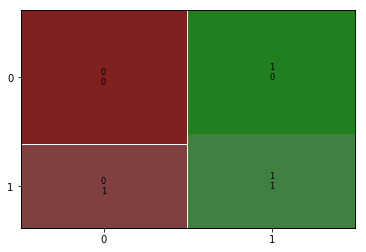

In [21]:
mosaic(train, ['Y', 'Sex_dummy'])
plt.show()

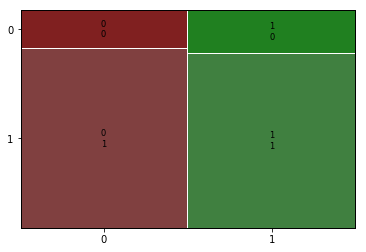

In [22]:
mosaic(train, ['Y', 'Education_dummy'])
plt.show()

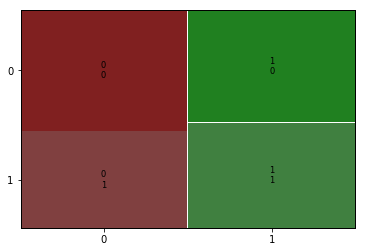

In [23]:
mosaic(train, ['Y', 'Marriage_dummy'])
plt.show()

### Heat map

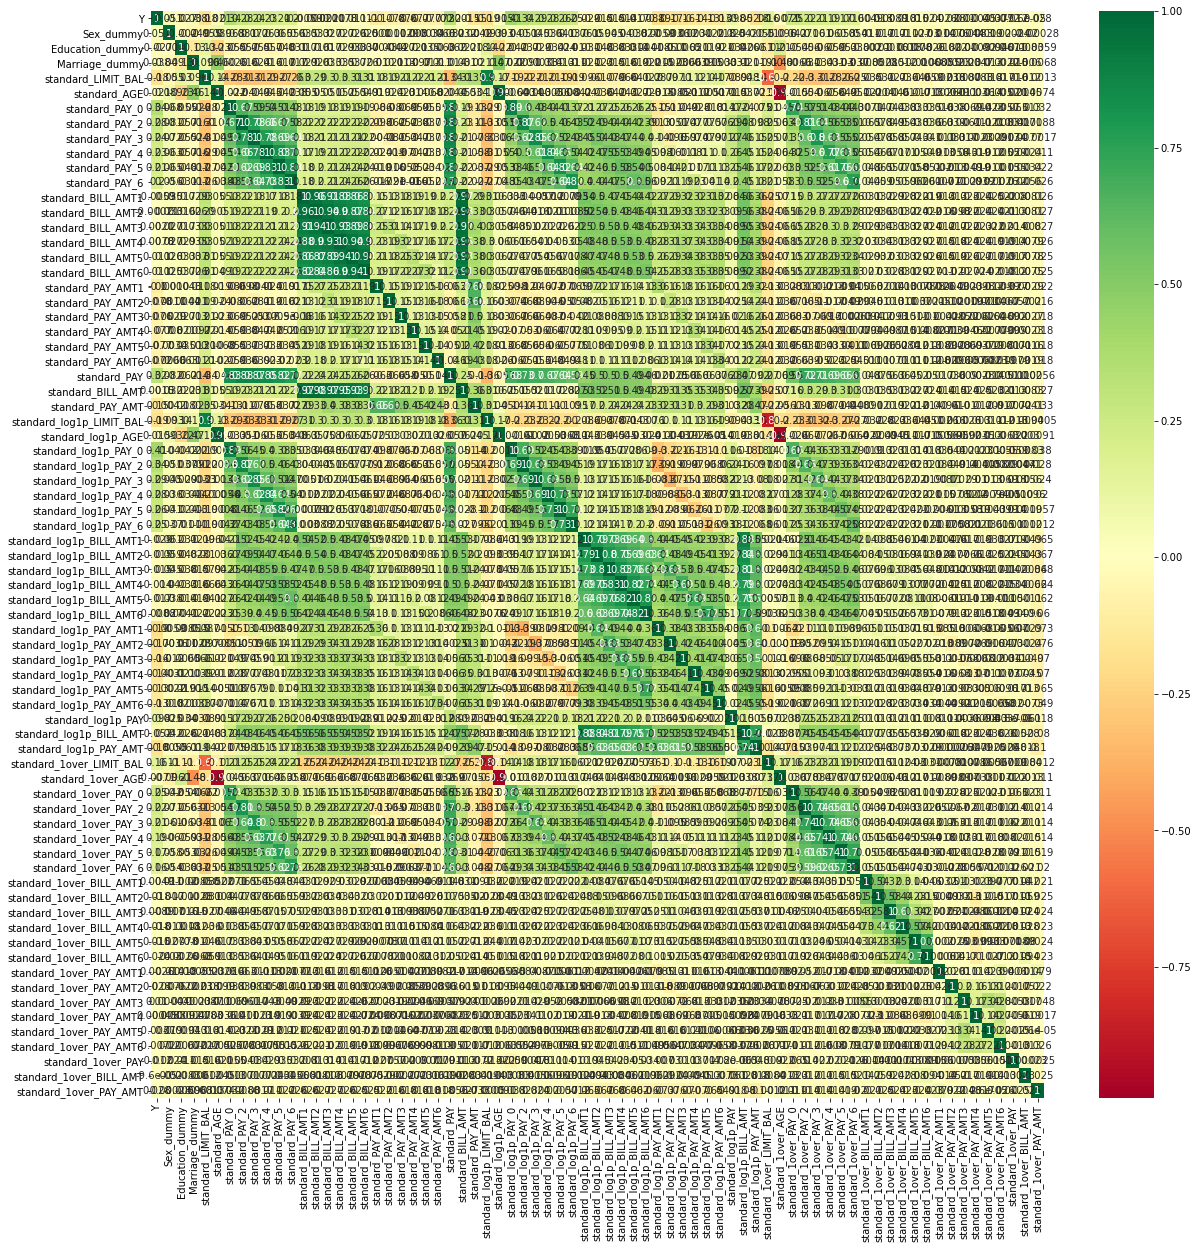

In [24]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Correlation

In [25]:
train.corr()

,Y,Sex_dummy,Education_dummy,Marriage_dummy,standard_LIMIT_BAL,standard_AGE,standard_PAY_0,standard_PAY_2,standard_PAY_3,standard_PAY_4,...,standard_1over_BILL_AMT6,standard_1over_PAY_AMT1,standard_1over_PAY_AMT2,standard_1over_PAY_AMT3,standard_1over_PAY_AMT4,standard_1over_PAY_AMT5,standard_1over_PAY_AMT6,standard_1over_PAY,standard_1over_BILL_AMT,standard_1over_PAY_AMT
Y,1.000000,0.050974,-0.027302,0.038414,-0.175863,0.021469,0.343264,0.276540,0.241177,0.225877,...,0.023784,0.002601,0.027761,0.010189,0.000455,-0.003701,-0.007178,-0.011948,-0.000096,0.028488
Sex_dummy,0.050974,1.000000,-0.002049,-0.049478,-0.055145,0.089243,0.067501,0.081112,0.072052,0.063099,...,-0.030023,-0.013503,0.007634,0.000435,0.008277,0.018939,0.019807,0.002396,-0.019710,-0.000277
Education_dummy,-0.027302,-0.002049,1.000000,-0.129758,0.126263,-0.234576,-0.054828,-0.056536,-0.055229,-0.057070,...,0.002623,-0.018418,-0.022496,-0.010355,0.000920,-0.009417,-0.006700,0.010933,-0.008298,-0.005933
Marriage_dummy,0.038414,-0.049478,-0.129758,1.000000,0.096480,0.458517,0.002603,-0.016202,-0.024454,-0.015877,...,-0.006843,0.000552,-0.002268,0.002269,0.004684,0.013497,-0.002218,-0.015068,-0.005972,-0.006769
standard_LIMIT_BAL,-0.175863,-0.055145,0.126263,0.096480,1.000000,0.136181,-0.279393,-0.314593,-0.309643,-0.289711,...,-0.059459,-0.002348,0.017761,0.008724,0.008278,0.017708,0.017081,-0.016104,-0.011636,-0.001312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
standard_1over_PAY_AMT5,-0.003701,0.018939,-0.009417,0.013497,0.017708,0.013848,-0.022764,-0.021350,-0.002906,-0.011610,...,-0.027073,0.022799,0.127849,0.339911,0.143574,1.000000,0.223227,0.001473,-0.013955,0.000026
standard_1over_PAY_AMT6,-0.007178,0.019807,-0.006700,-0.002218,0.017081,-0.005182,-0.005657,-0.008269,-0.001660,-0.005526,...,0.012341,0.094124,0.118972,0.283982,0.272452,0.223227,1.000000,0.001303,-0.012965,0.025550
standard_1over_PAY,-0.011948,0.002396,0.010933,-0.015068,-0.016104,-0.020965,-0.054846,0.004076,0.034214,0.029336,...,-0.001459,0.005976,0.001740,0.005267,0.005647,0.001473,0.001303,1.000000,-0.000227,0.002458
standard_1over_BILL_AMT,-0.000096,-0.019710,-0.008298,-0.005972,-0.011636,0.004535,-0.012722,0.007120,0.007710,0.002401,...,0.093554,0.001401,-0.051612,-0.016838,-0.018923,-0.013955,-0.012965,-0.000227,1.000000,-0.024604


### Chi-square

In [26]:
xlist=train.columns[1:4]
xlist=xlist.append(train.columns[6:12])
xlist=xlist.append(train.columns[24:25])

In [27]:
chiframe=pd.DataFrame(index=xlist,columns=["Chi2"])
for x in xlist:
    tab1=pd.crosstab(train['Y'],train[x])
    chi1=chi2_contingency(tab1,correction=False)
    chiframe.loc[x,"Chi2"]=chi1[0]

In [28]:
chiframe.sort_values("Chi2",ascending=False)

,Chi2
standard_PAY,1905.81
standard_PAY_0,1612.84
standard_PAY_2,1092
standard_PAY_3,802.218
standard_PAY_4,739.463
standard_PAY_5,670.114
standard_PAY_6,589.795
Sex_dummy,24.1389
Marriage_dummy,13.7089
Education_dummy,6.9247


In [29]:
col_selected1=["Sex_dummy","standard_PAY","standard_PAY_0","standard_PAY_2"]

In [30]:
col_selected1

['Sex_dummy', 'standard_PAY', 'standard_PAY_0', 'standard_PAY_2']

### Forward selection

In [31]:
import statsmodels.formula.api as smf

In [32]:
col_list=train.columns[4:6]
col_list=col_list.append(train.columns[12:24])
col_list=col_list.append(train.columns[25:27])
col_list

Index(['standard_LIMIT_BAL', 'standard_AGE', 'standard_BILL_AMT1',
       'standard_BILL_AMT2', 'standard_BILL_AMT3', 'standard_BILL_AMT4',
       'standard_BILL_AMT5', 'standard_BILL_AMT6', 'standard_PAY_AMT1',
       'standard_PAY_AMT2', 'standard_PAY_AMT3', 'standard_PAY_AMT4',
       'standard_PAY_AMT5', 'standard_PAY_AMT6', 'standard_BILL_AMT',
       'standard_PAY_AMT'],
      dtype='object')

In [33]:
def forward_mse_cv(data, col_X, col_y, cv = 5):
    columns = [ ]
    ss = [ ]
    n = [ ]
    for train_index, test_index in KFold(n_splits = cv, shuffle = True).split(data):
        lr = smf.ols(formula = col_y + '~1' , data = data.iloc[train_index]).fit()
        ss.append(sum((lr.predict(data.iloc[test_index][col_X]) - data.iloc[test_index][col_y])**2))
        n.append(len(test_index))
    MSE = sum(ss)/ sum(n)
    
    while len(columns) != len(col_X):
        mse_min = None
        index = 0
        for i in range(len(col_X)):
            if col_X[i] not in columns:
                cols = columns.copy()
                cols.append(col_X[i])
                ss = [ ]
                n = [ ]
                for train_index, test_index in KFold(n_splits = cv, shuffle = True).split(data):
                    lr = smf.ols(formula = col_y + '~' + '+'.join(cols) , data = data.iloc[train_index]).fit()
                    ss.append(sum((lr.predict(data.iloc[test_index][col_X]) - data.iloc[test_index][col_y])**2))
                    n.append(len(test_index))
                    
                mse = sum(ss)/ sum(n)
                if mse_min is None or mse_min > mse:
                    mse_min = mse
                    index = i
    
        print('Variable in model:', ', '.join(columns))
        print('{0: <50}     {1: <30}     {2: <15}'.format('Variable Entered', 'Mean Square Error before Entered',
                                                              'Mean Square Error after Entered'))
        print('{0: <50}     {1: <30}     {2: <15}'.format(col_X[index], "{0:.4f}".format(MSE), "{0:.4f}".format(mse_min)))
        print('Decision:', 'Enter' if mse_min < MSE else 'Do not enter')
        print('------------------------------------------------------------------------------------------------------------------------')
        
        if mse_min < MSE:
            columns.append(col_X[index])
            MSE = mse_min
        else:
            break
            
    return columns

In [34]:
col_selected2=forward_mse_cv(train, col_list, 'Y')

Variable in model: 
Variable Entered                                       Mean Square Error before Entered     Mean Square Error after Entered
standard_LIMIT_BAL                                     0.2501                             0.2424         
Decision: Enter
------------------------------------------------------------------------------------------------------------------------
Variable in model: standard_LIMIT_BAL
Variable Entered                                       Mean Square Error before Entered     Mean Square Error after Entered
standard_PAY_AMT                                       0.2424                             0.2402         
Decision: Enter
------------------------------------------------------------------------------------------------------------------------
Variable in model: standard_LIMIT_BAL, standard_PAY_AMT
Variable Entered                                       Mean Square Error before Entered     Mean Square Error after Entered
standard_BILL_AMT5          

In [35]:
col_selected2

['standard_LIMIT_BAL',
 'standard_PAY_AMT',
 'standard_BILL_AMT5',
 'standard_AGE',
 'standard_BILL_AMT1',
 'standard_BILL_AMT3']

In [36]:
col_selected1.extend(col_selected2)

In [37]:
col_selected1

['Sex_dummy',
 'standard_PAY',
 'standard_PAY_0',
 'standard_PAY_2',
 'standard_LIMIT_BAL',
 'standard_PAY_AMT',
 'standard_BILL_AMT5',
 'standard_AGE',
 'standard_BILL_AMT1',
 'standard_BILL_AMT3']

### Logistic Regression

In [38]:
logit_model=sm.Logit(train['Y'],train[col_selected1]).fit()

Optimization terminated successfully.
         Current function value: 0.622861
         Iterations 6


In [39]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 9290
Model:                          Logit   Df Residuals:                     9280
Method:                           MLE   Df Model:                            9
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1014
Time:                        15:29:52   Log-Likelihood:                -5786.4
converged:                       True   LL-Null:                       -6439.3
Covariance Type:            nonrobust   LLR p-value:                1.693e-275
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Sex_dummy              0.0484      0.045      1.065      0.287      -0.041       0.138
standard_PAY          -0.2166      0.501     -0.432      0.666      -1.199       0.766
standard_PAY_0         4.4748      0.336     13.309      0.000       3.816       5.134
standard_PAY_2         1.3005      0.367      3.542      0.000       0.581       2.020
standard_LIMIT_BAL    -0.9705      0.210     -4.611      0.000      -1.383      -0.558
standard_PAY_AMT     -27.0893      3.254     -8.324      0.000     -33.468     -20.711
standard_BILL_AMT5     7.2942      0.890      8.191      0.000       5.549       9.040
standard_AGE           0.1054      0.134      0.784      0.433      -0.158       0.369
standard_BILL_AMT1    -6.7222      1.082     -6.211      0.000      -8.843      -4.601
standard_BILL_AMT3    -4.4172      2.110     -2.093      0.036      -8.553      -0.281
======================================================================================
"""

In [40]:
col_new=[]
for i in range(len(logit_model.pvalues)):
    if logit_model.pvalues[i] <= 0.05:
        col_new.append(col_selected1[i])

In [41]:
X_train=train[col_new]
y_train=train['Y']
X_test=test[col_new]
y_test=test['Y']

In [42]:
logit_model=sm.Logit(y_train,X_train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.622976
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 9290
Model:                          Logit   Df Residuals:                     9283
Method:                           MLE   Df Model:                            6
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1012
Time:                        15:29:52   Log-Likelihood:                -5787.4
converged:                       True   LL-Null:                       -6439.3
Covariance Type:            nonrobust   LLR p-value:                1.715e-278
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
standard_PAY_0         4.4028      0.241     18.259      0.000       3.930       4.875
standard_PAY_2         1.1922      0.234      5.106      0.000       0.735       1.650
standard_LIMIT_BAL    -0.9293      0.204     -4.548      0.000      -1.330      -0.529
standard_PAY_AMT     -27.0791      3.256     -8.316      0.000     -33.462     -20.697
standard_BILL_AMT5     7.0495      0.871      8.098      0.000       5.343       8.756
standard_BILL_AMT1    -6.5588      1.069     -6.138      0.000      -8.653      -4.464
standard_BILL_AMT3    -4.2257      2.058     -2.054      0.040      -8.258      -0.193
======================================================================================
"""

In [43]:
logreg = LogisticRegressionCV(cv=10, random_state=0,multi_class='multinomial')
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=10, multi_class='multinomial', random_state=0)

In [44]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1489  516]
 [ 764 1213]]


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      2005
           1       0.70      0.61      0.65      1977

    accuracy                           0.68      3982
   macro avg       0.68      0.68      0.68      3982
weighted avg       0.68      0.68      0.68      3982



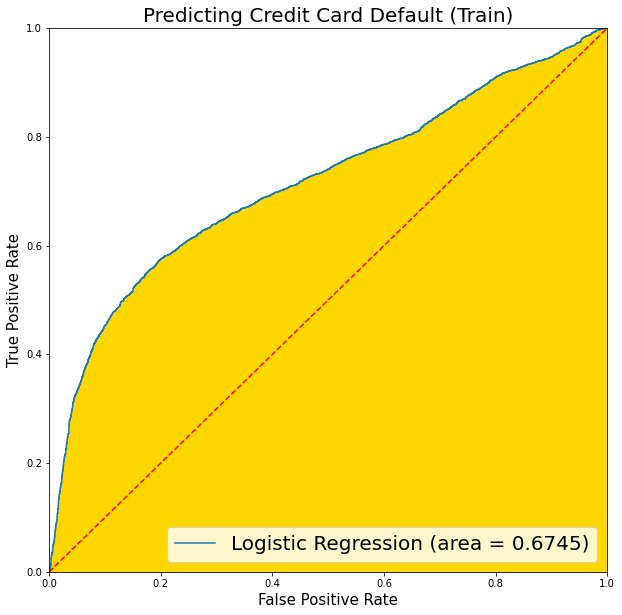

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_train, logreg.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])
plt.figure(figsize=(10,10))
plt.fill_between(fpr, tpr, color='gold' )
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Predicting Credit Card Default (Train)', size=20)
plt.legend(loc="lower right", fontsize=20)
plt.show()

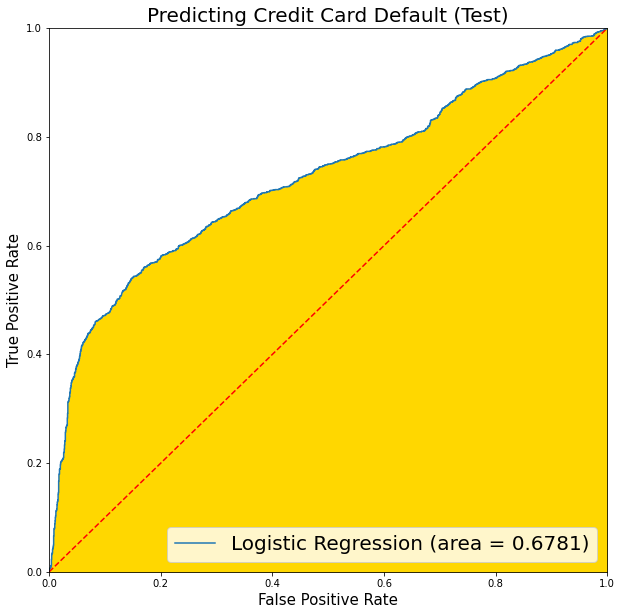

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.fill_between(fpr, tpr, color='gold' )
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Predicting Credit Card Default (Test)', size=20)
plt.legend(loc="lower right", fontsize=20)
plt.show()

## Part 4. Fine Tuning of Random Forest Models
Build random forest classification model  using all features prepared in previous parts. The performance will be evaluated with AUC score given that there is no obvious overfitting. 

In [49]:
Xtrain=train.iloc[:,1:]
ytrain=train['Y']
Xtest=test.iloc[:,1:]
ytest=test['Y']

In [50]:
clf=RandomForestClassifier(max_depth=7,n_estimators=150,min_samples_leaf=5,min_samples_split=5,max_features=3,bootstrap=True).fit(Xtrain,ytrain)
predictedOutcome_train=clf.predict(Xtrain)
predictedProb_train=clf.predict_proba(Xtrain)
predictedOutcome_test=clf.predict(Xtest)
predictedProb_test=clf.predict_proba(Xtest)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ytest, predictedOutcome_test)
print(confusion_matrix)

[[1656  349]
 [ 745 1232]]


In [52]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predictedOutcome_test))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      2005
           1       0.78      0.62      0.69      1977

    accuracy                           0.73      3982
   macro avg       0.73      0.72      0.72      3982
weighted avg       0.73      0.73      0.72      3982



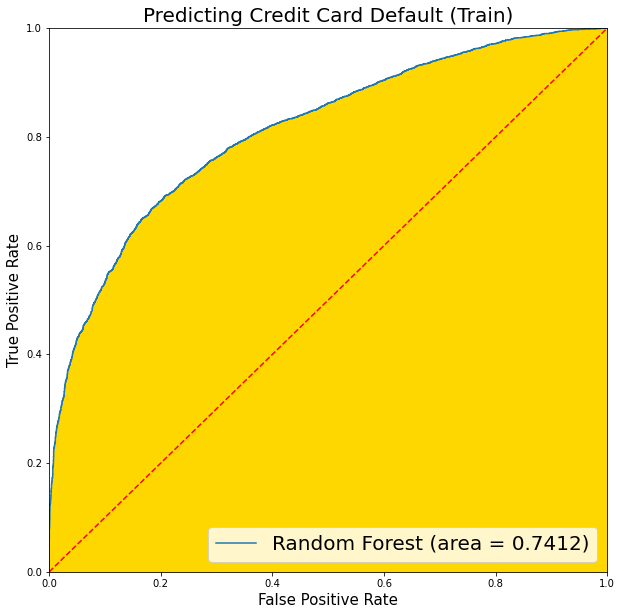

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
clf_roc_auc = roc_auc_score(ytrain, predictedOutcome_train)
fpr, tpr, thresholds = roc_curve(ytrain, predictedProb_train[:,1])
plt.figure(figsize=(10,10))
plt.fill_between(fpr, tpr, color='gold' )
plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Predicting Credit Card Default (Train)', size=20)
plt.legend(loc="lower right", fontsize=20)
plt.show()

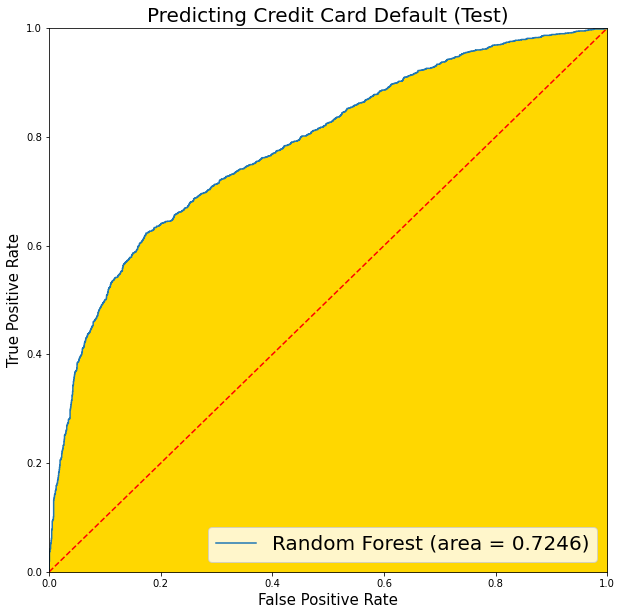

In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
clf_roc_auc = roc_auc_score(ytest, predictedOutcome_test)
fpr, tpr, thresholds = roc_curve(ytest, predictedProb_test[:,1])
plt.figure(figsize=(10,10))
plt.fill_between(fpr, tpr, color='gold' )
plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Predicting Credit Card Default (Test)', size=20)
plt.legend(loc="lower right", fontsize=20)
plt.show()